In [1]:
%matplotlib inline

In [2]:
%run ~/src/starry/notebooks/notebook_setup.py

In [164]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpmath import ellipf, ellipe, appellf1
from tqdm.notebook import tqdm

In [4]:
def E(phi, k2):
    return float(ellipe(phi, k2).real)


def F(phi, k2):
    return float(ellipf(phi, k2).real)

## Recursion formulae for I

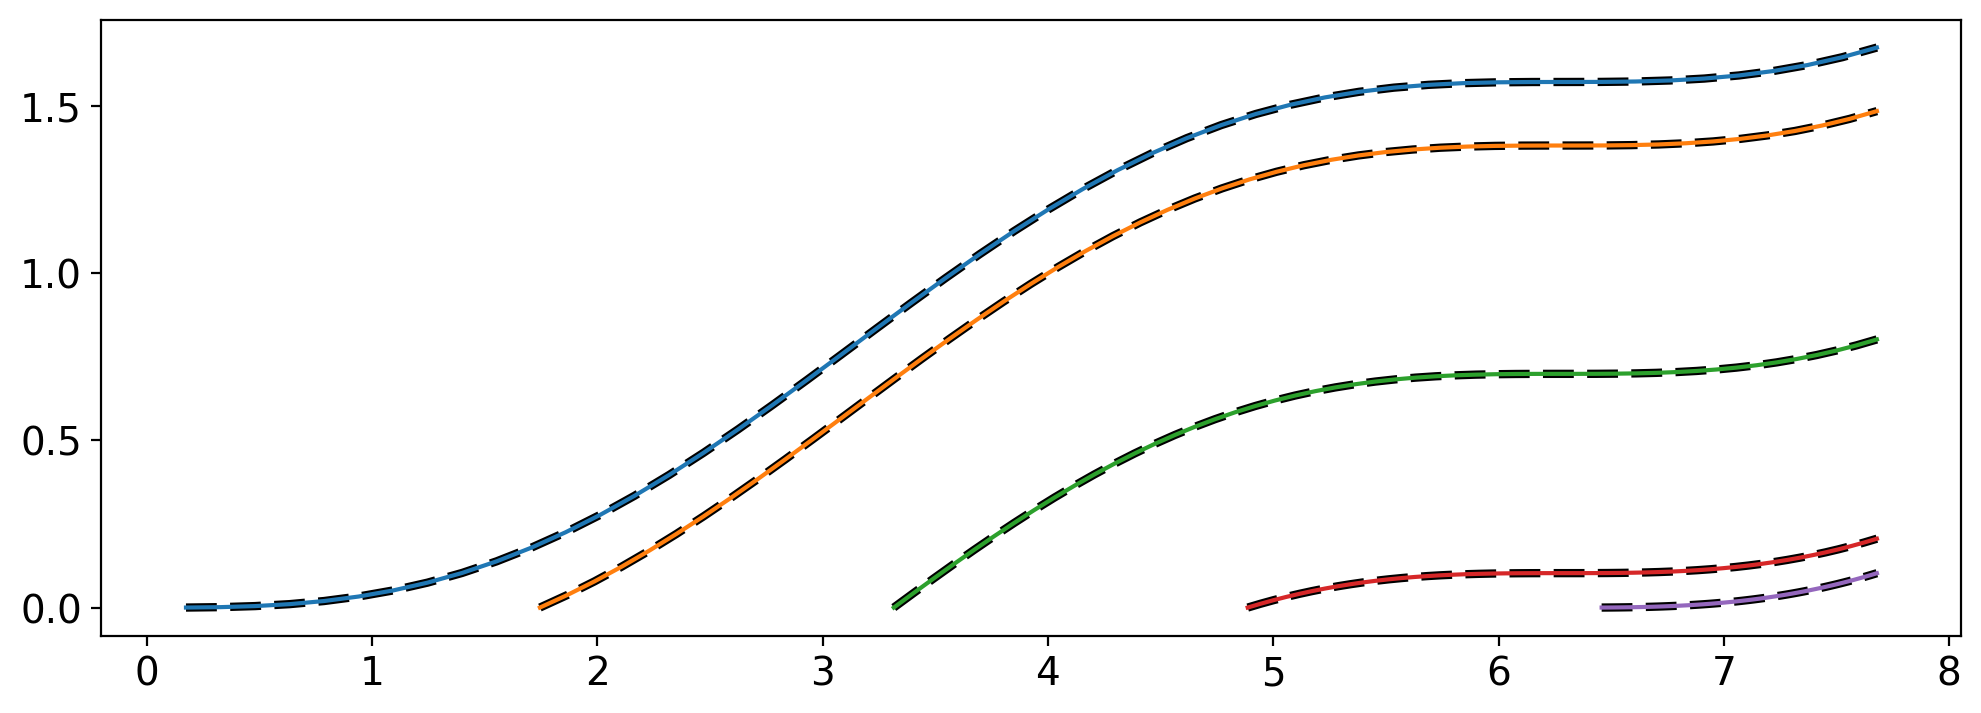

In [189]:
def Iexact(v, kappa1, kappa2):
    func = lambda x: np.sin(x) ** (2 * v)
    res, _ = quad(func, 0.5 * kappa1, 0.5 * kappa2, epsabs=1e-12, epsrel=1e-12,)
    return res


def I(v, kappa1, kappa2):
    """
    This replaces (D43), (D45), and (D49) for recursive 
    computation of I_v in both the k^2 < 1 and k^2 >= 1
    cases.
    
    """
    if v == 0:
        return 0.5 * (kappa2 - kappa1)
    else:
        s1 = np.sin(0.5 * kappa1)
        c1 = np.cos(0.5 * kappa1)
        term1 = s1 ** (2 * v - 1) * c1
        s2 = np.sin(0.5 * kappa2)
        c2 = np.cos(0.5 * kappa2)
        term2 = s2 ** (2 * v - 1) * c2
        term = 0.5 * (term2 - term1)
        return (1.0 / v) * (0.5 * (2 * v - 1) * I(v - 1, kappa1, kappa2) - term)

    
# Validation
for kappa1 in np.array([10, 100, 190, 280, 370]) * np.pi / 180:
    kappa2 = np.linspace(kappa1, 440 * np.pi / 180, 50)
    plt.plot(kappa2, [Iexact(1, kappa1, x) for x in kappa2], "k--", lw=3)
    plt.plot(kappa2, [I(1, kappa1, x) for x in kappa2])

## Solver for I

In [225]:
def solve(N, kappa1, kappa2):
    
    # Useful quantities
    s1 = np.sin(0.5 * kappa1)
    s2 = np.sin(0.5 * kappa2)
    s12 = s1 ** 2
    s22 = s2 ** 2
    term1 = s1 * np.cos(0.5 * kappa1)
    term2 = s2 * np.cos(0.5 * kappa2)
    
    # Lower boundary
    I = np.empty(N + 1)
    I[0] = 0.5 * (kappa2 - kappa1)
    
    # Recurse upward
    for v in range(1, N + 1):
        term = 0.5 * (term2 - term1)
        I[v] = (1.0 / v) * (0.5 * (2 * v - 1) * I[v - 1] - term)
        term1 *= s12
        term2 *= s22
        
    return I

## Solver stability

In [228]:
def solve_numerical(N, kappa1, kappa2):
    return np.array([Iexact(v, kappa1, kappa2) for v in range(N + 1)])

def random_kappa():
    """Random (kappa1, kappa2) in the range [0, 2pi] with kappa2 > kappa1."""
    kappa1 = 2 * np.pi * np.random.random()
    kappa2 = kappa1 + (2 * np.pi - kappa1) * np.random.random()
    return kappa1, kappa2

ntimes = 1000
N = 20
logdiff = np.zeros((ntimes, N + 1))
for i in tqdm(range(ntimes)):
    k = random_k()
    kappa1, kappa2 = random_kappa()
    logdiff[i] = np.log10(np.maximum(1e-16, np.abs(solve(N, kappa1, kappa2) - solve_numerical(N, kappa1, kappa2))))

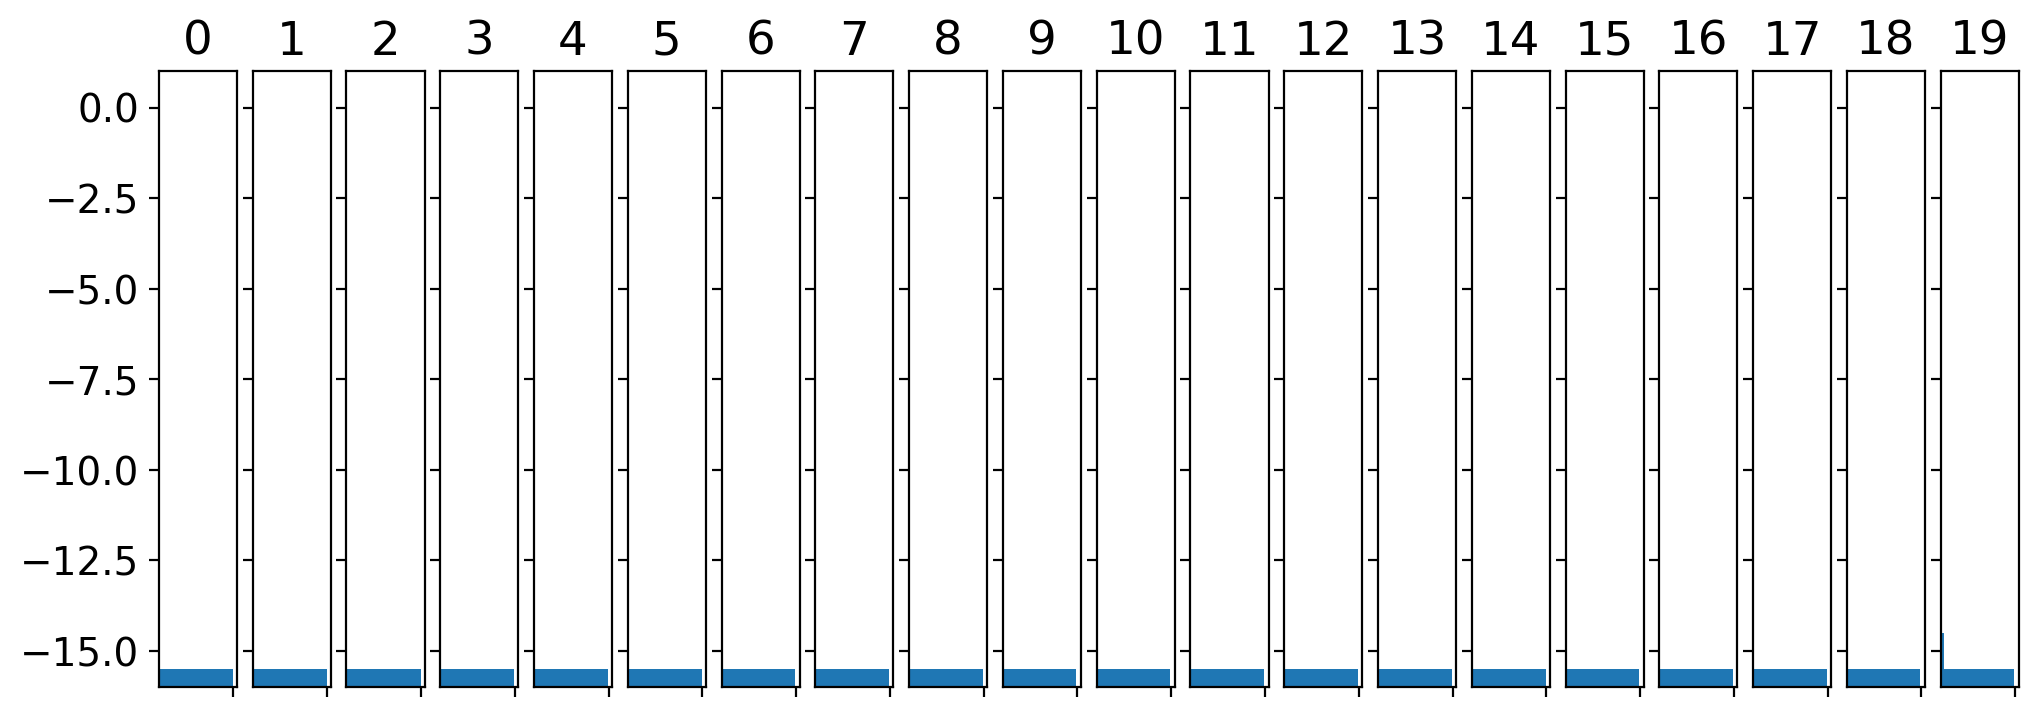

In [229]:
fig, ax = plt.subplots(1, N, sharex=True, sharey=True)
ax[0].set_ylim(-16, 1)
ax[0].set_xscale("log")
ax[0].set_xticklabels([])
for i, axis in enumerate(ax):
    axis.set_title(i)
    axis.hist(logdiff[:, i], orientation="horizontal", bins=np.arange(-16.5, 0))

## Recursion formulae for J

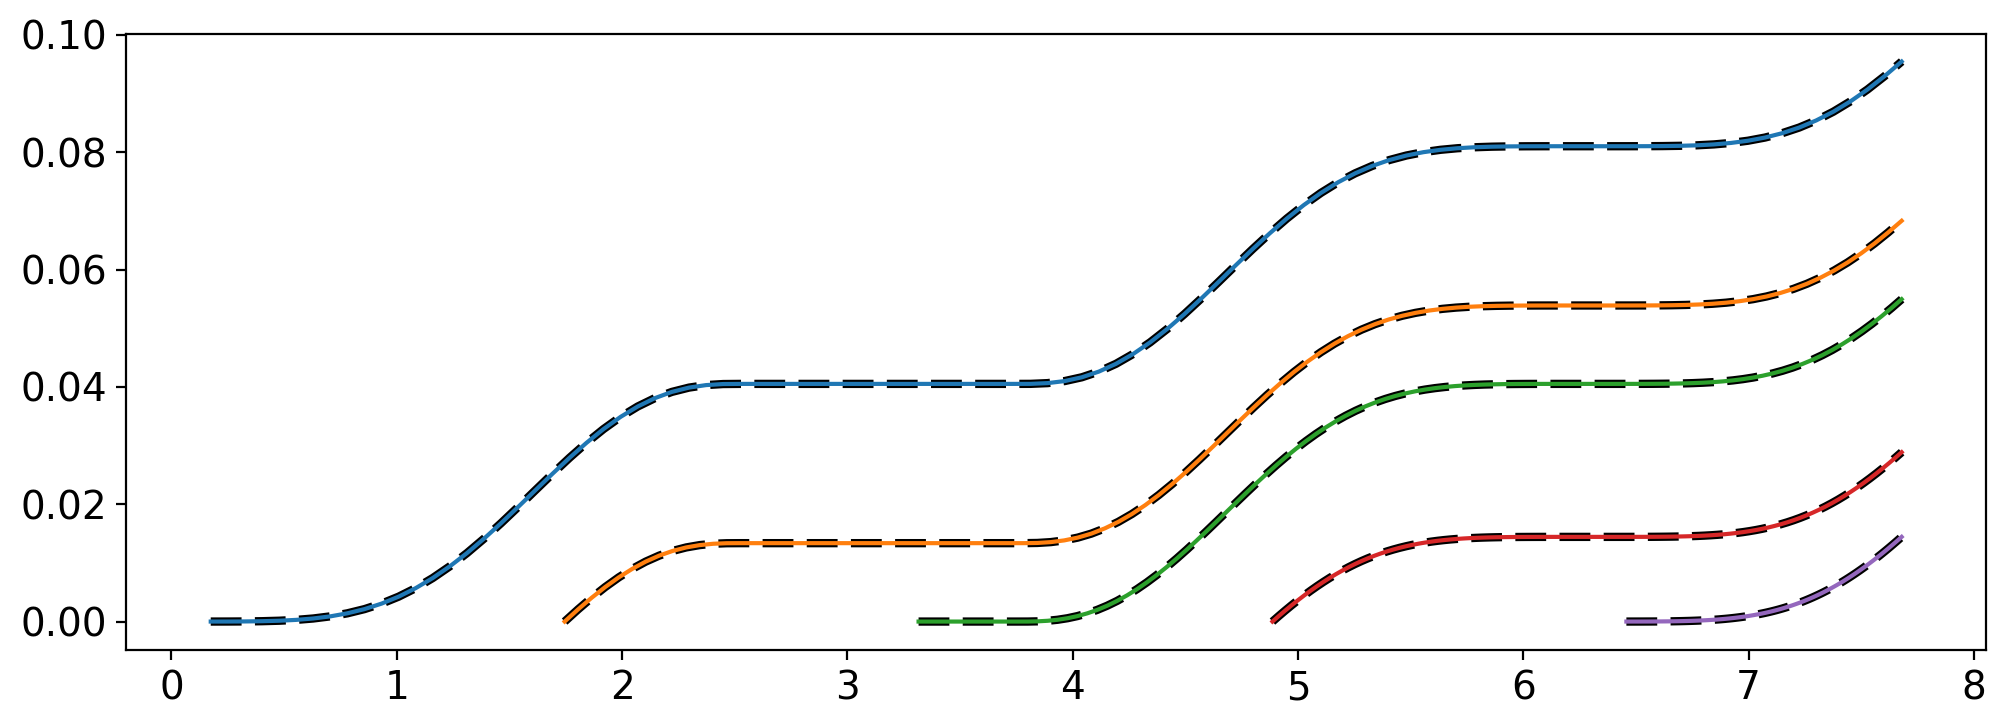

In [85]:
def Jexact(v, k, kappa1, kappa2):
    func = lambda x: np.sin(x) ** (2 * v) * (1 - k ** (-2) * np.sin(x + 0j) ** 2) ** 1.5
    res, _ = quad(func, 0.5 * kappa1, 0.5 * kappa2, epsabs=1e-12, epsrel=1e-12,)
    return res


def J(v, k, kappa1, kappa2):
    """
    This replaces all equations for recursive computation of J_v.
    
    """
    k2 = k ** 2
    km2 = k ** -2
    x2 = 0.5 * kappa2
    x1 = 0.5 * kappa1
    z2 = np.sin(x2) * np.cos(x2) * np.sqrt(max(0.0, 1 - km2 * np.sin(x2) ** 2))
    z1 = np.sin(x1) * np.cos(x1) * np.sqrt(max(0.0, 1 - km2 * np.sin(x1) ** 2))

    if v == 0:

        dE = E(x2, km2) - E(x1, km2)
        dF = F(x2, km2) - F(x1, km2)
        resid = km2 * (z2 - z1)
        return (1 / 3) * (2 * (2 - km2) * dE + (km2 - 1) * dF + resid)

    elif v == 1:

        dE = E(x2, km2) - E(x1, km2)
        dF = F(x2, km2) - F(x1, km2)
        resid = ((3 * np.sin(x2) ** 2 + 4) * km2 - 6) * z2 - (
            (3 * np.sin(x1) ** 2 + 4) * km2 - 6
        ) * z1
        return (1 / 15) * (
            (-3 * k2 + 13 - 8 * km2) * dE + (3 * k2 - 7 + 4 * km2) * dF + resid
        )

    else:
        resid = k2 * (
            (1 - km2 * np.sin(x2) ** 2) ** 2 * np.sin(x2) ** (2 * v - 4) * z2
            - (1 - km2 * np.sin(x1) ** 2) ** 2 * np.sin(x1) ** (2 * v - 4) * z1
        )
        return (
            2 * (v + (v - 1) * k2 + 1) * J(v - 1, k, kappa1, kappa2)
            - (2 * v - 3) * k2 * J(v - 2, k, kappa1, kappa2)
            + resid
        ) / (2 * v + 3)


# Validation
k = 0.95
for kappa1 in np.array([10, 100, 190, 280, 370]) * np.pi / 180:
    kappa2 = np.linspace(kappa1, 440 * np.pi / 180, 100)
    plt.plot(kappa2, [Jexact(2, k, kappa1, x) for x in kappa2], "k--", lw=3)
    plt.plot(kappa2, [J(2, k, kappa1, x) for x in kappa2])

## Tridiagonal solve for J

In [255]:
def JN(N, k, kappa1, kappa2):
    # TODO: Series solution
    func = lambda x: np.sin(x) ** (2 * N) * (1 - k ** (-2) * np.sin(x + 0j) ** 2) ** 1.5
    res, _ = quad(func, 0.5 * kappa1, 0.5 * kappa2, epsabs=1e-12, epsrel=1e-12,)
    return res


def solve(N, k, kappa1, kappa2):
    """
    Return the array J[0 .. N], computed recursively using
    a tridiagonal solver and a lower boundary condition
    (analytic in terms of elliptic integrals) and an upper
    boundary condition (computed as a series solution).
    
    """
    # Useful quantities
    k2 = k ** 2
    km2 = k ** -2
    x2 = 0.5 * kappa2
    x1 = 0.5 * kappa1
    s2 = np.sin(x2)
    s1 = np.sin(x1)
    s12 = s1 ** 2
    s22 = s2 ** 2
    z2 = s2 * np.cos(x2) * np.sqrt(max(0.0, 1 - km2 * s22))
    z1 = s1 * np.cos(x1) * np.sqrt(max(0.0, 1 - km2 * s12))
    
    # Boundary conditions
    dE = E(x2, km2) - E(x1, km2)
    dF = F(x2, km2) - F(x1, km2)
    resid = km2 * (z2 - z1)
    f0 = (1 / 3) * (2 * (2 - km2) * dE + (km2 - 1) * dF + resid)
    fN = JN(N, k, kappa1, kappa2)
    
    # Set up the tridiagonal problem
    a = np.empty(N - 1)
    b = np.empty(N - 1)
    c = np.empty(N - 1)
    term2 = k2 * z2 * (1 - km2 * s22) ** 2
    term1 = k2 * z1 * (1 - km2 * s12) ** 2
    for i, v in enumerate(range(2, N + 1)):
        amp = 1.0 / (2 * v + 3)
        a[i] = -2 * (v + (v - 1) * k2 + 1) * amp
        b[i] = (2 * v - 3) * k2 * amp
        c[i] = (term2 - term1) * amp
        term2 *= s22
        term1 *= s12

    # Add the boundary conditions
    c[0] -= b[0] * f0
    c[-1] -= fN
    
    # Construct the tridiagonal matrix
    A = np.diag(a, 0) + np.diag(b[1:], -1) + np.diag(np.ones(N - 2), 1)
    
    # Solve
    soln = np.linalg.solve(A, c)
    return np.concatenate(([f0], soln, [fN]))

## Solver stability

In [240]:
def solve_numerical(N, k, kappa1, kappa2):
    return np.array([JN(v, k, kappa1, kappa2) for v in range(N + 1)])


def random_k():
    """Random k in the range [0, 1] or [1, 20]."""
    if np.random.random() < 0.5:
        return np.random.random()
    else:
        return 1 + 19 * np.random.random()

def random_kappa():
    """Random (kappa1, kappa2) in the range [0, 2pi] with kappa2 > kappa1."""
    kappa1 = 2 * np.pi * np.random.random()
    kappa2 = kappa1 + (2 * np.pi - kappa1) * np.random.random()
    return kappa1, kappa2

ntimes = 1000
N = 20
logdiff = np.zeros((ntimes, N + 1))
for i in tqdm(range(ntimes)):
    k = random_k()
    kappa1, kappa2 = random_kappa()
    logdiff[i] = np.log10(np.maximum(1e-16, np.abs(solve(N, k, kappa1, kappa2) - solve_numerical(N, k, kappa1, kappa2))))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  after removing the cwd from sys.path.


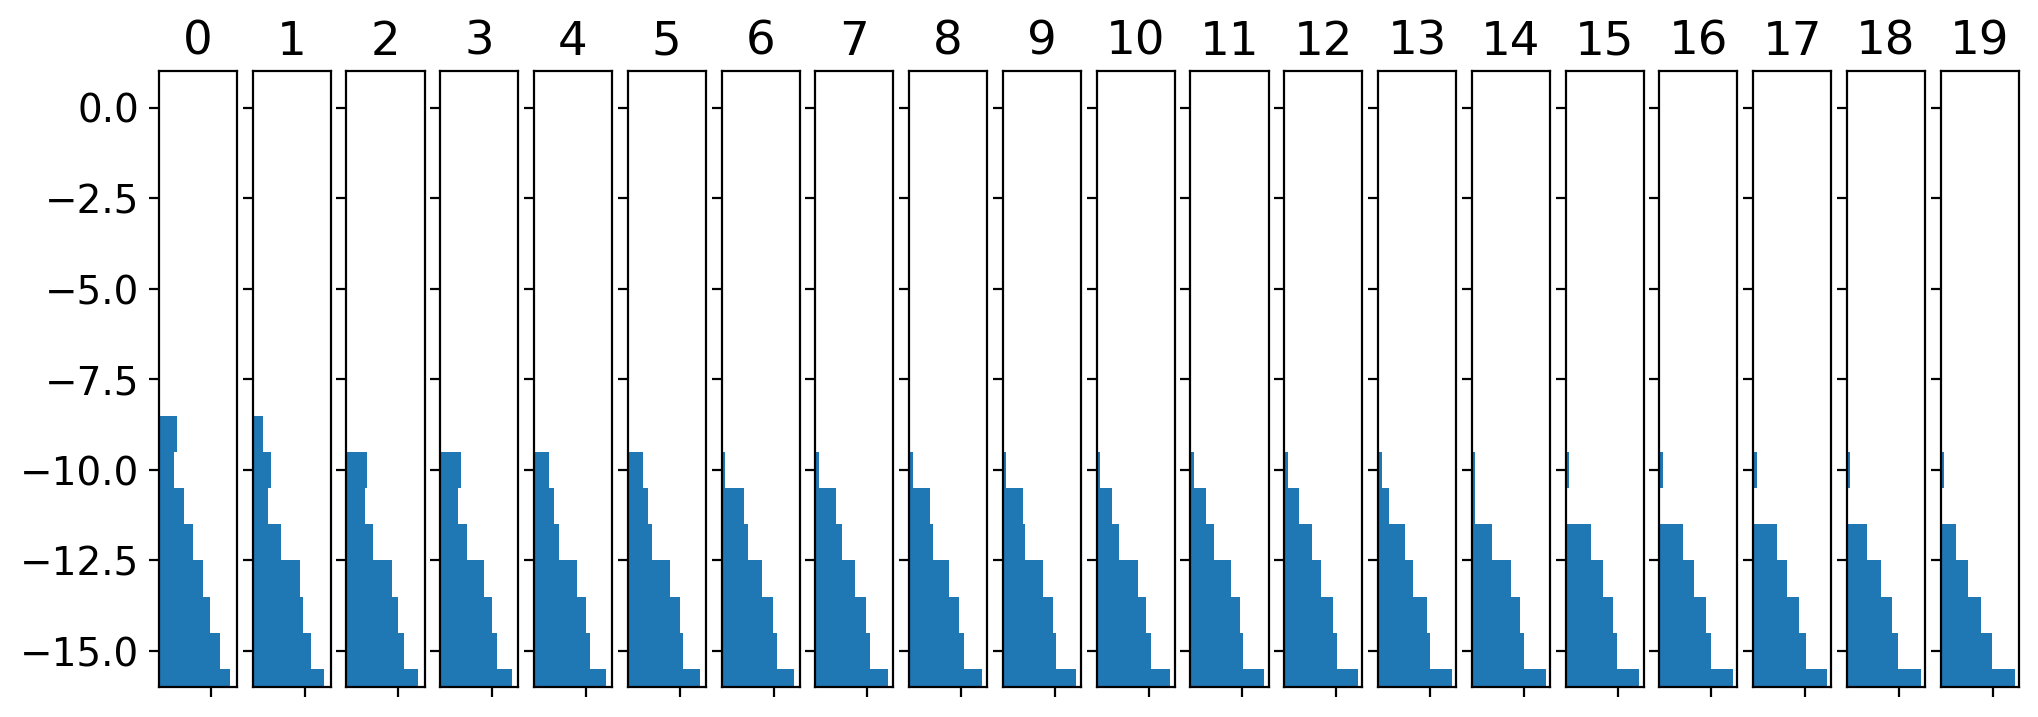

In [241]:
fig, ax = plt.subplots(1, N, sharex=True, sharey=True)
ax[0].set_ylim(-16, 1)
ax[0].set_xscale("log")
ax[0].set_xticklabels([])
for i, axis in enumerate(ax):
    axis.set_title(i)
    axis.hist(logdiff[:, i], orientation="horizontal", bins=np.arange(-16.5, 0))

In [288]:
def JAppell(N, k, kappa1, kappa2):
    s2 = np.sign(np.cos(0.5 * kappa2)) * np.sin(0.5 * kappa2)
    s1 = np.sign(np.cos(0.5 * kappa1)) * np.sin(0.5 * kappa1)

    term2 = s2 ** (2 * v + 1) * float(appellf1(v + 0.5, 0.5, -1.5, v + 1.5, s2 ** 2, s2 ** 2 / k ** 2))
    term1 = s1 ** (2 * v + 1) * float(appellf1(v + 0.5, 0.5, -1.5, v + 1.5, s1 ** 2, s1 ** 2 / k ** 2))

    res = (term2 - term1) / (2 * v + 1)
    
    if kappa1 < np.pi and kappa2 > np.pi:
        res += 2 * float(appellf1(v + 0.5, 0.5, -1.5, v + 1.5, 1, 1 / k ** 2)) / (2 * v + 1)
    
    return res